In [2]:
# Example performance of HMM-based realignment:

%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import glob
import sys

[sys.path.append(f) for f in glob.glob('utils/*')]
from preprocess import DataStruct
from firingrate import raster2FR
from plotting_utils import figSize
from lineplots import plotsd
from stabilizer_utils import *
from HMM_utils import *


from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import FactorAnalysis, PCA


files = glob.glob('D:/T5_ClosedLoop/*')

### train linear regression on day 0, get baseline performance measure


In [3]:
from recalibration_utils import *

# Get initial day performance and decoder:
day0       = DataStruct(files[2])
train_frac = 0.5
task       = 'cursor'

day0_r2, day0_decoder = traintest_DecoderSupervised(day0, train_frac = train_frac, task = task)


print('Performance on day 0 with recalibration: R^2 = ',day0_r2)

Performance on day 0 with recalibration: R^2 =  0.3314413769391978


In [16]:
from recalibration_utils import *
from copy import deepcopy

train_frac = 0.5
task       = 'cursor'


# HMM setup:
gridSize     = 20  
stayProb      = 0.9999
vmKappa       = 2
probThreshold = 0.4

nStates       = gridSize**2
stateTrans    = np.eye(nStates)*stayProb #Define the state transition matrix, which assumes uniform transition probability of transitioning to new state
targLocs      = get_DiscreteTargetGrid(day0, gridSize = gridSize, task = task)

for x in range(nStates):
    idx                = np.setdiff1d(np.arange(nStates), x)
    stateTrans[x, idx] = (1-stayProb)/(nStates-1)
pStateStart = np.zeros((nStates,1)) + (1/nStates)


date         = [day0.date]
models       = list()
scores       = np.zeros((4, 12)) # rows are 0 - no recalibration; 1 - mean recalibration; 2 - full recalibration; 3 - HMM recalibration
scores[:, 0] = day0_r2

hmm_scores    = np.zeros((12,))
hmm_scores[0] = day0_r2

hmm_dec = deepcopy(day0_decoder)
for i in range(11):
    file        = files[i + 3]
    new_day     = DataStruct(file)
    date.append(new_day.date)
    
    # 0th column is reserved for initial day decoder performance:
    scores[0, i + 1], _ = traintest_DecoderSupervised(struct = new_day, decoder = deepcopy(day0_decoder), adapt_means = False, train_frac = train_frac, task = task)
    scores[1, i + 1], _ = traintest_DecoderSupervised(struct = new_day, decoder = deepcopy(day0_decoder), adapt_means = True, train_frac = train_frac, task = task)
    scores[2, i + 1], _ = traintest_DecoderSupervised(struct = new_day, decoder = None, train_frac = train_frac, task = task)
    
    # Precision parameter for the von mises distribution.
    hmm_score, hmm_dec, r2 = traintest_DecoderHMMUnsupervised(struct   = new_day, decoder  = deepcopy(day0_decoder), stateTrans = stateTrans, pStateStart = pStateStart, 
                                                        targLocs = targLocs, vmKappa = vmKappa, probThreshold = probThreshold, train_frac = train_frac, task = task)           
    scores[3, i + 1] = hmm_score
    
    dailyhmm_score, _, _ = traintest_DecoderHMMUnsupervised(struct = new_day, decoder = hmm_dec, stateTrans = stateTrans, pStateStart = pStateStart, 
                                                        targLocs = targLocs, vmKappa = vmKappa, probThreshold = probThreshold, train_frac = train_frac, task = task)           
    hmm_scores[i + 1] = dailyhmm_score
    
    print(new_day.date, ' finished')
    #print(r2)
    


2016.10.05  finished
2016.10.07  finished
2016.10.10  finished
2016.10.12  finished
2016.10.13  finished
2016.10.17  finished
2016.10.19  finished
2016.10.24  finished
2016.10.26  finished
2016.10.31  finished
2016.12.06  finished


Text(0, 0.5, 'R^2')

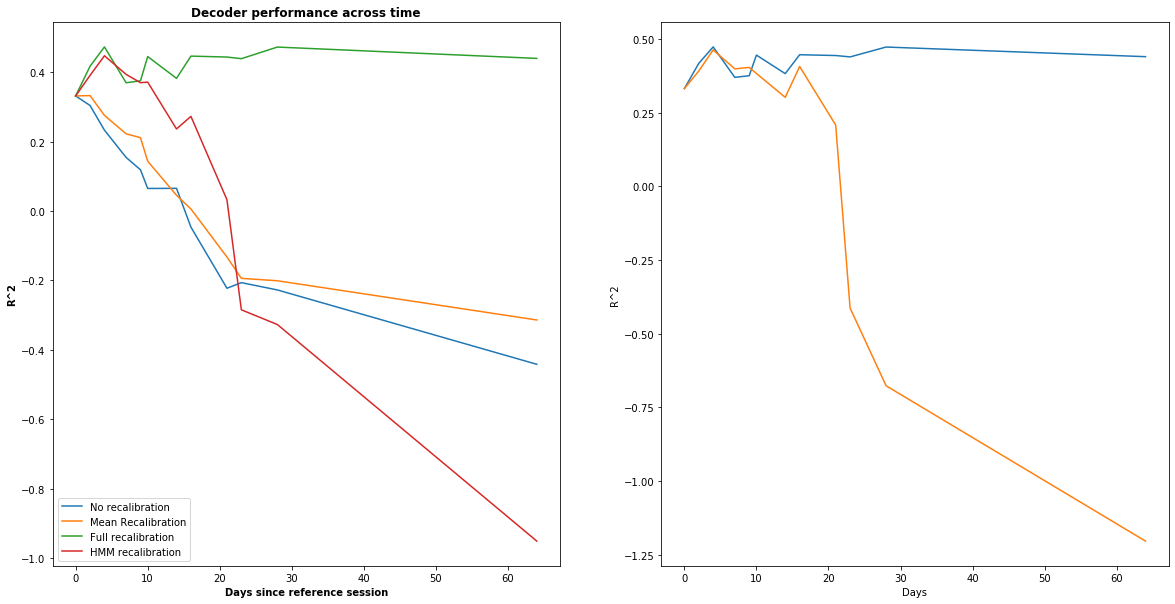

In [17]:
from preprocess import daysBetween
days = [daysBetween(day0.date, date[i]) for i in range(len(date))]


figSize(10, 20)

plt.subplot(1, 2, 1)
labels = ['No recalibration', 'Mean Recalibration', 'Full recalibration', 'HMM recalibration']
for i in range(4):
    plt.plot(days, scores[i, :].T, label = labels[i])
    
plt.xlabel('Days since reference session', fontweight = 'bold')
plt.ylabel('R^2', fontweight = 'bold')
#plt.xticks(np.arange(len(date)), date, rotation = 40, fontweight = 'bold')
plt.title('Decoder performance across time', fontweight = 'bold')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(days, scores[2, :], label = 'Full recalibration')
plt.plot(days, hmm_scores, label = 'HMM (consecutive updates)')
plt.xlabel('Days')
plt.ylabel('R^2')